In [1]:
# setup

%load_ext lab_black
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# recombine data

from combine import recombine

data = recombine("../data/potholes_1.csv", "../data/potholes_2.csv")

In [3]:
# extract days from date data by converting date to time, creating completion time variable, and turning to an int

data = data.drop_duplicates(subset=["SERVICE REQUEST NUMBER"])
data["creation_date"] = pd.to_datetime(data["CREATION DATE"])
data["completion_date"] = pd.to_datetime(data["COMPLETION DATE"])
data["creation_year"] = pd.DatetimeIndex(data["creation_date"]).year
data["creation_date"] = pd.to_datetime(data["creation_date"], format="%m/%d/%Y")
data["completion_date"] = pd.to_datetime(data["completion_date"], format="%m/%d/%Y")
data["completion_time"] = data["completion_date"] - data["creation_date"]
data["completion_time"] = data["completion_time"].apply(lambda x: x.days)

In [4]:
# inefficiently clean data

data.drop("CREATION DATE", axis=1, inplace=True)
data.drop("COMPLETION DATE", axis=1, inplace=True)
data.drop("STATUS", axis=1, inplace=True)
data.drop("SERVICE REQUEST NUMBER", axis=1, inplace=True)
data.drop("TYPE OF SERVICE REQUEST", axis=1, inplace=True)
data.drop("CURRENT ACTIVITY", axis=1, inplace=True)
data.drop("MOST RECENT ACTION", axis=1, inplace=True)
data.drop("STREET ADDRESS", axis=1, inplace=True)
data.drop("X COORDINATE", axis=1, inplace=True)
data.drop("Y COORDINATE", axis=1, inplace=True)
data.drop("SSA", axis=1, inplace=True)
data.drop("LATITUDE", axis=1, inplace=True)
data.drop("LONGITUDE", axis=1, inplace=True)
data.drop("LOCATION", axis=1, inplace=True)
data.drop("creation_date", axis=1, inplace=True)
data.drop("completion_date", axis=1, inplace=True)
data.drop("ZIP", axis=1, inplace=True)
data.drop("Ward", axis=1, inplace=True)
data.drop("Police District", axis=1, inplace=True)
data.drop("NUMBER OF POTHOLES FILLED ON BLOCK", axis=1, inplace=True)
data = data.dropna()
data["community_area"] = data["Community Area"].astype(int)
data.drop("Community Area", axis=1, inplace=True)

In [5]:
# make a list of total pothole count per community area

potc = (
    data.groupby(["community_area"])["creation_year"].count().reset_index(name="count")
)
potc = potc.drop(labels=0, axis=0)
Ytemp = potc["count"]
Ytemp.reset_index(drop=True)

0      9944
1     15371
2      5407
3      7055
4      6318
      ...  
72     7602
73     5084
74     6680
75     2276
76     8915
Name: count, Length: 77, dtype: int64

In [6]:
# make a list of average service request completion time by community area

compt = data.groupby(["community_area"]).agg({"completion_time": "mean"})
compt = compt.drop(labels=0, axis=0)
Yb = compt

In [7]:
# import surface area in Km^2 of every community area

areas = pd.read_csv("../data/surfaceareas.csv")
areas["community_area"] = areas["Area Number"]
areas["area"] = areas["Area"]
areas.drop("Area Number", axis=1, inplace=True)
areas.drop("Area", axis=1, inplace=True)

In [8]:
# import crime data and make a list of average yearly crime by community area

crimed = pd.read_csv("../data/Crimes_data.csv")
crimed["community_area"] = crimed["Community Area"]
crimed["crime_rate"] = crimed["ID"]
crimes = crimed[["community_area", "crime_rate"]]
crimes.dropna()
crime = crimes.groupby(["community_area"]).count()
crime["crime_rate"] = crime["crime_rate"] / 5

In [9]:
# import per capita yearly income from census data by community area

incomes = pd.read_csv("../data/chicago_census_data.csv")
incomes = incomes.drop(labels=77, axis=0)
incomes["avg_income"] = incomes["PER CAPITA INCOME "]
incomes["below_poverty"] = incomes["PERCENT HOUSEHOLDS BELOW POVERTY"]
incomes["community_area"] = incomes["Community Area Number"].astype(int)
income = incomes[["community_area", "avg_income", "below_poverty"]]

In [10]:
# import population by community area data

pops = pd.read_csv("../data/population.csv")
pops["population"] = pops["Total Population"]
pops["community_area"] = pops["GeogKey"]
pop = pops[["community_area", "population"]]

In [11]:
# create population density for every community area (in people/km^2)

temp = pd.merge(pop, areas, on="community_area")
temp["popdensity"] = temp["population"] / temp["area"]
temp.drop("area", axis=1, inplace=True)
temp.drop("population", axis=1, inplace=True)
popdens = temp

In [12]:
# create pothole density for every community area (in potholes/km^2)

t = Ytemp.to_frame().reset_index()
t["community_area"] = t["index"]
t.drop("index", axis=1, inplace=True)
temp2 = pd.merge(t, areas, on="community_area")
temp2["density"] = temp2["count"] / temp2["area"]
temp2.drop("area", axis=1, inplace=True)
temp2.drop("count", axis=1, inplace=True)
Ya = temp2["density"]
Ya.index += 1

In [13]:
# create an X matric for the regression with avg yearly income, population density, and crime rate

Xt = pd.merge(income, crime, on="community_area")
X = pd.merge(Xt, popdens, on="community_area")
X.drop("community_area", axis=1, inplace=True)
X.index += 1

In [14]:
# add the constant term to the matrix

Xc = sm.add_constant(X)

In [15]:
# regression of pothole density by community area on crime rate, population density, yearly income, and below poverty line population

esta = sm.OLS(Ya, Xc)
est1 = esta.fit()
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                density   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     40.23
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           1.14e-17
Time:                        04:22:17   Log-Likelihood:                -528.43
No. Observations:                  77   AIC:                             1067.
Df Residuals:                      72   BIC:                             1079.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           704.2558    114.430      6.154      0.000     476.143     932.369
avg_income       -0.0011      0.002     -0.464      0.644      -0.006       0.004
below_poverty   -13.2680      3.208     -4.136      0.000     -19.663      -6.873
crime_rate        0.0563      0.038      1.465      0.147      -0.020       0.133
popdensity        0.1150      0.012      9.953      0.000       0.092       0.138
==============================================================================
Omnibus:                        3.283   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.194   Jarque-Bera (JB):                3.010
Skew:                           0.170   Prob(JB):                        0.222
Kurtosis:                       3.907   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# regression of average service request completion time by community area on crime rate, population density,
# yearly income, and below poverty line population

estb = sm.OLS(Yb, Xc)
est2 = estb.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        completion_time   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     3.367
Date:                Tue, 22 Mar 2022   Prob (F-statistic):             0.0139
Time:                        04:22:17   Log-Likelihood:                -281.90
No. Observations:                  77   AIC:                             573.8
Df Residuals:                      72   BIC:                             585.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            29.3321      4.657      6.299      0.000      20.049      38.615
avg_income       -0.0001   9.47e-05     -1.122      0.266      -0.000    8.25e-05
below_poverty    -0.2400      0.131     -1.839      0.070      -0.500       0.020
crime_rate        0.0017      0.002      1.056      0.295      -0.001       0.005
popdensity        0.0013      0.000      2.857      0.006       0.000       0.002
==============================================================================
Omnibus:                        7.551   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                3.465
Skew:                           0.253   Prob(JB):                        0.177
Kurtosis:                       2.093   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

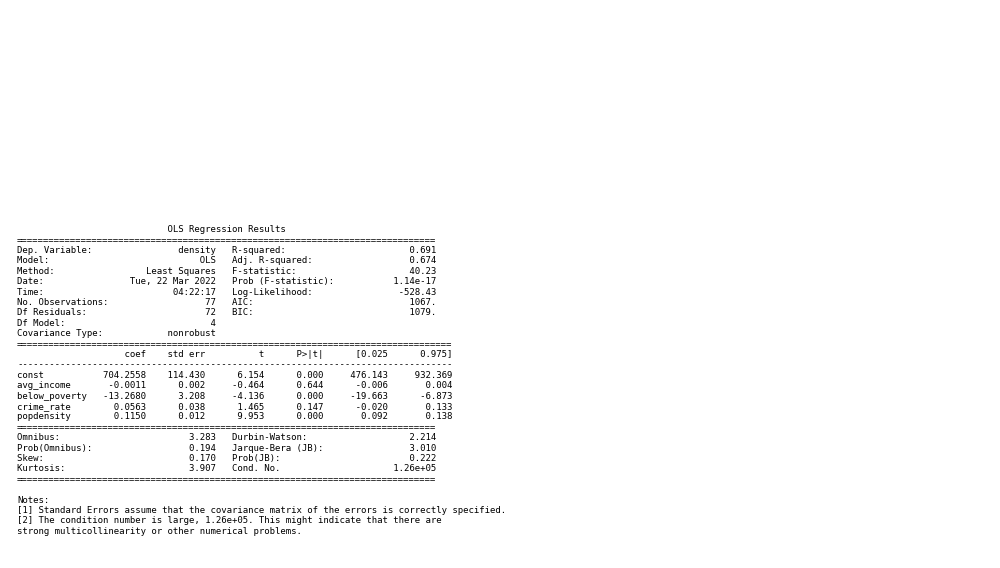

In [17]:
# exporting pictures of the first regression summary

plt.rc("figure", figsize=(14, 8))
plt.text(0.01, 0.05, str(est1.summary()), {"fontsize": 9}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.savefig("../artifacts/reg1.png")

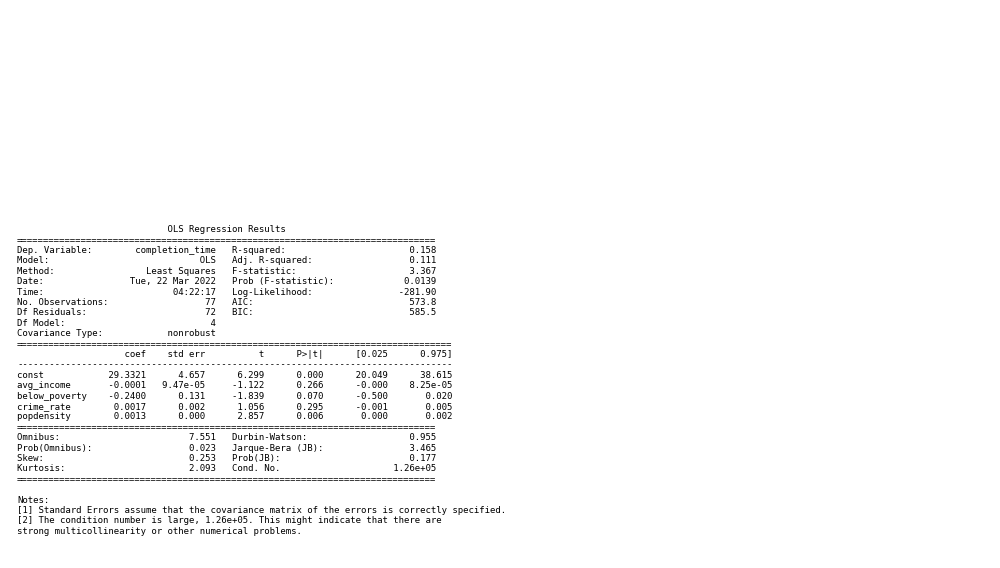

In [18]:
# exporting pictures of the second regression summary

plt.rc("figure", figsize=(14, 8))
plt.text(0.01, 0.05, str(est2.summary()), {"fontsize": 9}, fontproperties="monospace")
plt.axis("off")
plt.tight_layout()
plt.savefig("../artifacts/reg2.png")